In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


In [3]:
from sklearn.impute import KNNImputer

In [4]:
df = pd.read_csv(r'C:\Users\kusha\OneDrive\Desktop\diabetes_prediction_dataset.csv')


In [5]:
df.replace({"???": None, "Unknown": None}, inplace=True)
df['HbA1c_level'] = df.groupby('diabetes')['HbA1c_level'].transform(lambda x: x.fillna(x.median()))


In [6]:
knn_imputer = KNNImputer(n_neighbors=5)
df[['bmi', 'blood_glucose_level', 'HbA1c_level']] = knn_imputer.fit_transform(df[['bmi', 'blood_glucose_level', 'HbA1c_level']])



In [7]:
ordinal_mapping = {
    'Physical Activity Level': {'Low': 0, 'Moderate': 1, 'High': 2}
}
for col, mapping in ordinal_mapping.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)



In [8]:
df = pd.get_dummies(df, columns=['smoking_history', 'gender'], drop_first=True)


In [9]:
scaler = StandardScaler()
df[['blood_glucose_level', 'HbA1c_level']] = scaler.fit_transform(df[['blood_glucose_level', 'HbA1c_level']])


In [10]:
minmax_scaler = MinMaxScaler()
df[['bmi', 'age']] = minmax_scaler.fit_transform(df[['bmi', 'age']])


In [11]:
Q1 = df[['bmi', 'blood_glucose_level']].quantile(0.25)
Q3 = df[['bmi', 'blood_glucose_level']].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[['bmi', 'blood_glucose_level']] < (Q1 - 1.5 * IQR)) | (df[['bmi', 'blood_glucose_level']] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [12]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]


In [14]:
        X_train.drop(columns=to_drop, inplace=True)
        X_test.drop(columns=to_drop, inplace=True)
        print(f"Dropped highly correlated features: {to_drop}")


Dropped highly correlated features: []


In [15]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.01].index.tolist()


In [18]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]


In [26]:
print(f"Selected Features: {selected_features}")


Selected Features: ['HbA1c_level', 'blood_glucose_level', 'bmi', 'age', 'hypertension', 'heart_disease']


In [31]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [32]:
print(f"Final Train Shape: {X_train_resampled.shape}, Test Shape: {X_test.shape}")

Final Train Shape: (137426, 6), Test Shape: (18248, 6)


In [33]:
#checking 

In [34]:
print(X_train_resampled.isnull().sum())  
print(X_test.isnull().sum())  


HbA1c_level            0
blood_glucose_level    0
bmi                    0
age                    0
hypertension           0
heart_disease          0
dtype: int64
HbA1c_level            0
blood_glucose_level    0
bmi                    0
age                    0
hypertension           0
heart_disease          0
dtype: int64


In [35]:
print(X_train_resampled.dtypes)
print(X_test.dtypes)


HbA1c_level            float64
blood_glucose_level    float64
bmi                    float64
age                    float64
hypertension             int64
heart_disease            int64
dtype: object
HbA1c_level            float64
blood_glucose_level    float64
bmi                    float64
age                    float64
hypertension             int64
heart_disease            int64
dtype: object


In [36]:
print(X_train_resampled.mean(axis=0))  
print(X_train_resampled.std(axis=0))   


HbA1c_level            0.605573
blood_glucose_level    0.298279
bmi                    0.206255
age                    0.640798
hypertension           0.147861
heart_disease          0.091598
dtype: float64
HbA1c_level            1.206217
blood_glucose_level    0.974634
bmi                    0.053491
age                    0.271290
hypertension           0.354964
heart_disease          0.288459
dtype: float64


In [37]:
#modeling

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [39]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [40]:
y_pred = rf_model.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, y_pred)

In [44]:
precision = precision_score(y_test, y_pred)

In [46]:
recall = recall_score(y_test, y_pred)

In [55]:
f1 = f1_score(y_test, y_pred)

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [57]:
class_report = classification_report(y_test, y_pred)

In [58]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9431
Precision: 0.5106
Recall: 0.6763
F1-score: 0.5819
Confusion Matrix:
[[16486   693]
 [  346   723]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     17179
           1       0.51      0.68      0.58      1069

    accuracy                           0.94     18248
   macro avg       0.75      0.82      0.78     18248
weighted avg       0.95      0.94      0.95     18248



In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

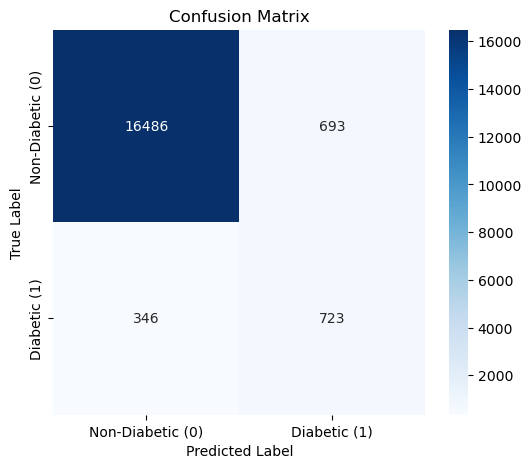

In [60]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Non-Diabetic (0)", "Diabetic (1)"], 
            yticklabels=["Non-Diabetic (0)", "Diabetic (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()